# SP500 Notebook Analyssis

## Libraries section

In [1]:
#Handing data 
import pandas as pd
import numpy as np
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Pymoo multi-objective optimization 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population
#Finance libraries 
import yfinance as yf
import yesg
#Plugins
from tqdm import tqdm #Timing iteration
#from itertools import compress 
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS
from Plugins import evaluation
#Finance libraries 
from finquant import efficient_frontier

## Recovering data

In [2]:
assets_info = pd.read_csv('data/AssetsInfo/full_sp500.csv', index_col=0)
best_assets = pd.read_csv('data/AssetsInfo/best_sp500.csv', index_col=0)
prices = pd.read_csv('data/Historical/historical_sp500.csv', index_col=0)
returns= pd.read_csv('data/Historical/returns_sp500.csv', index_col=0)

In [3]:
best_assets

,exp_risk,exp_return
PG,0.187486,-0.049778
LLY,0.280345,-0.428443
JNJ,0.170589,0.017951
MCK,0.220989,-0.397686
MCD,0.172431,-0.032738
BRK-B,0.188141,-0.081184
AMGN,0.209147,-0.160057
IBM,0.204320,-0.138105
ED,0.200776,-0.116415


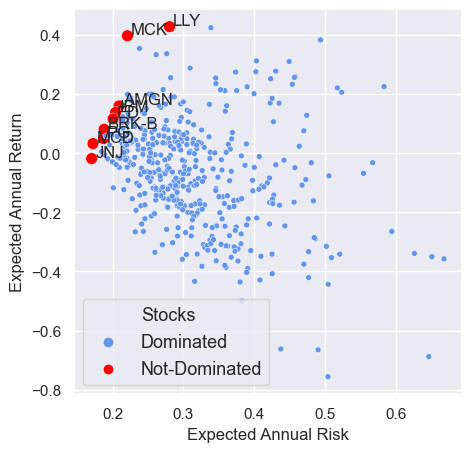

In [4]:
fig = plt.figure(figsize=(5,5))
my_plotting.plot_assets(assets_info, best_assets)

## Problem Definition (REDUCED)

In [5]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index], assets_info.loc[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)

In [6]:
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

## Solving using different methods

In [7]:
eps = np.array([0.01,0.01])
colors = ['#f0f2fa','#8da0cb', '#1b9e77']

### Das-Dennis

In [15]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=9)
F_das, ESG_das =pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das_best_eps, 1e-6)
print('Total', FA_das.shape)
print('Eps-Mejores', FA_das_best_eps.shape)
print('Mejores', FA_das_best.shape)

24310it [00:14, 1625.47it/s]
11045it [00:00, 32029.83it/s]

Total (24310, 2)
Eps-Mejores (11045, 2)
Mejores (84, 2)


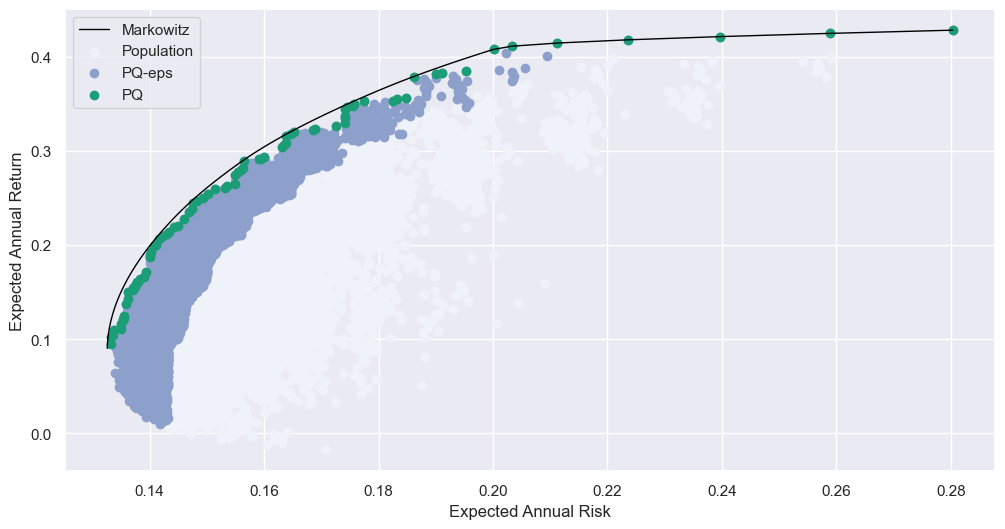

In [16]:
frames = [FA_das, FA_das_best_eps, FA_das_best]
labels = ['Population', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

### NSGA-II

In [17]:
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
termination = get_termination("n_gen", 250)
nsgaii = NSGA2(pop_size=100,repair=pymoo_extras.Portfolio_Repair())

In [18]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii_best_eps, 1e-6)
print('Total', FA_nsgaii.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)
print('Mejores', FA_nsgaii_best.shape)

25000it [00:53, 464.42it/s]
22796it [00:02, 8902.73it/s] 

Total (25000, 2)
Eps-Mejores (22796, 2)
Mejores (2126, 2)


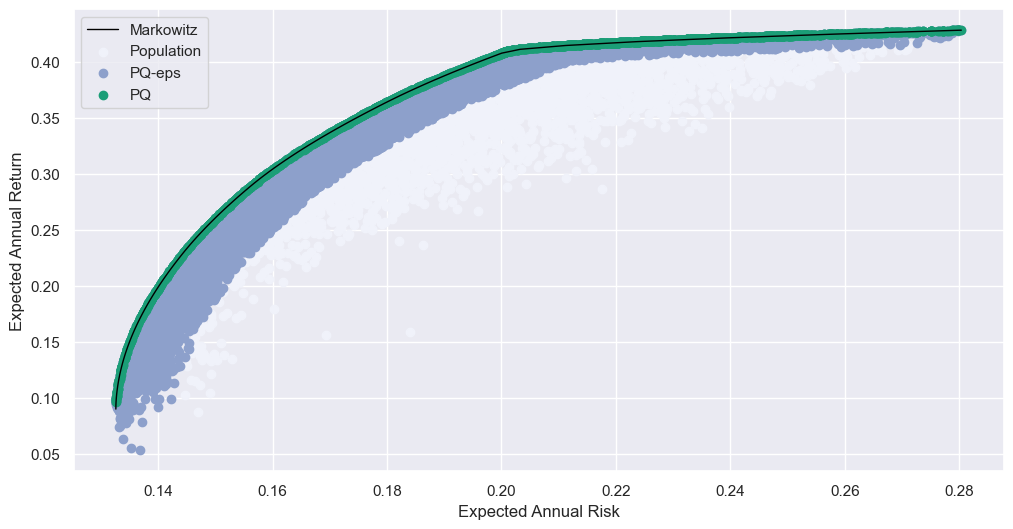

In [19]:
frames = [FA_nsgaii, FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['Population', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

### SMS-EMOA

In [20]:
from pymoo.termination import get_termination
from pymoo.algorithms.moo.sms import SMSEMOA
termination = get_termination("n_gen", 250)
sms = SMSEMOA(pop_size=100, repair=pymoo_extras.Portfolio_Repair())

In [21]:
X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)
print('Total', FA_sms.shape)
print('Eps-Mejores', FA_sms_best_eps.shape)
print('Mejores', FA_sms_best.shape)

25000it [01:06, 378.10it/s]
24763it [00:03, 6265.13it/s]

Total (25000, 2)
Eps-Mejores (24763, 2)
Mejores (2332, 2)


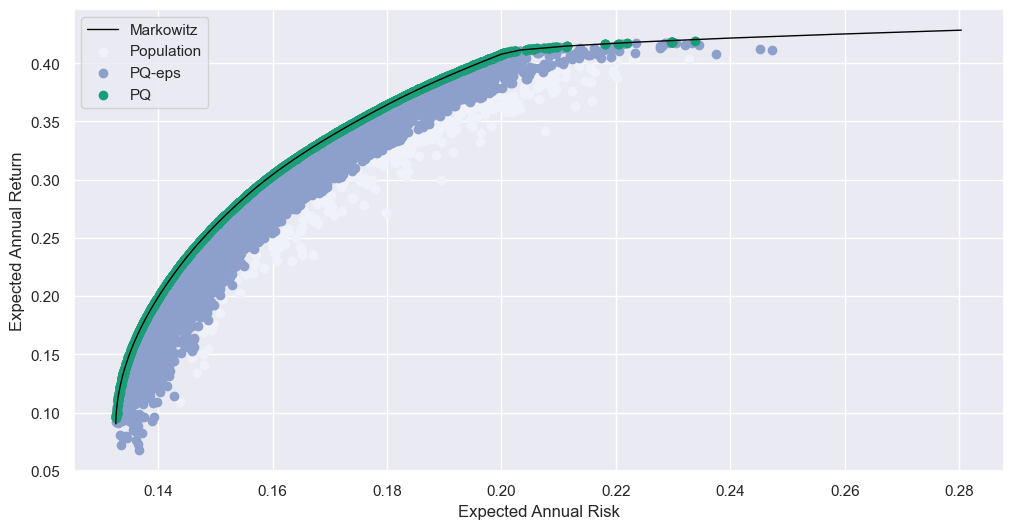

In [22]:
frames = [FA_sms, FA_sms_best_eps, FA_sms_best]
labels = ['Population', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

### Markowitz + Directed Search

In [23]:
X_mkds = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)
print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

25000it [01:07, 368.25it/s]
24260it [00:04, 5397.79it/s]

Total (25000, 2)
Mejores (3544, 2)
Eps-Mejores (24260, 2)


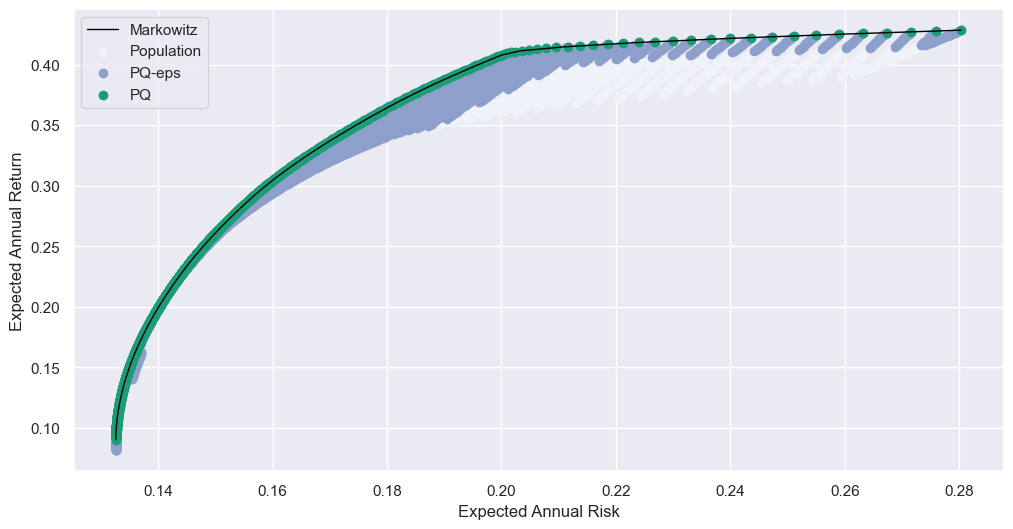

In [24]:
frames = [FA_mkds, FA_mkds_best_eps, FA_mkds_best]
labels = ['Population', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

## Saving Solutions

In [25]:
#Number of executions
n_ejec = 20
path = 'Solutions/SP500/'
np.save(path+'ef_R.npy', ef_R)

In [27]:
## Das-Dennis solutions
for i in range(n_ejec):  
    X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=9)
    F_das, ESG_das =pymoo_extras.eval_weights(portfolio_problem, X_das)
    FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
    FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
    #FA_das_best = ArchievingStrategies.get_best_opt(FA_das_best_eps, 1e-6)
    np.save(path+'X_das_'+str(i)+'.npy', X_das)
    FA_das.to_csv(path+'FA_das_'+str(i)+'.csv')
    FA_das_best_eps.to_csv(path+'FA_das_eps'+str(i)+'.csv')

24310it [00:16, 1471.41it/s]
24310it [00:16, 1482.85it/s]
24310it [00:17, 1394.94it/s]
24310it [00:19, 1264.42it/s]
24310it [00:20, 1172.28it/s]
24310it [00:20, 1203.79it/s]
24310it [00:18, 1325.21it/s]
24310it [00:22, 1090.27it/s]
24310it [00:18, 1281.47it/s]
24310it [00:19, 1260.74it/s]
24310it [00:20, 1196.42it/s]
24310it [00:19, 1222.91it/s]
24310it [00:19, 1250.33it/s]
24310it [00:19, 1262.50it/s]
24310it [00:25, 971.87it/s] 
24310it [00:20, 1209.31it/s]
24310it [00:18, 1286.25it/s]
24310it [00:25, 959.21it/s] 
24310it [00:21, 1144.19it/s]
24310it [00:19, 1217.04it/s]


In [28]:
#NSGA-II solutions
for i in range(n_ejec):  
    X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
    FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
    FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
    #FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii_best_eps, 1e-6)
    np.save(path +'X_nsgaii_'+str(i)+'.npy', X_nsgaii)
    FA_nsgaii.to_csv(path +'FA_nsgaii_'+str(i)+'.csv')
    FA_nsgaii_best_eps.to_csv(path +'FA_nsgaii_eps'+str(i)+'.csv')

25000it [00:58, 428.52it/s]
25000it [00:57, 437.64it/s]
25000it [00:55, 453.63it/s]
25000it [01:11, 350.68it/s]
25000it [00:59, 416.94it/s]
25000it [01:03, 391.89it/s]
25000it [00:56, 443.30it/s]
25000it [01:08, 365.12it/s]
25000it [01:29, 280.47it/s]
25000it [01:00, 413.12it/s]
25000it [01:02, 398.87it/s]
25000it [01:16, 327.88it/s]
25000it [01:02, 397.58it/s]
25000it [01:04, 389.35it/s]
25000it [01:02, 402.81it/s]
25000it [01:01, 404.85it/s]
25000it [01:06, 377.30it/s]
25000it [01:08, 366.63it/s]
25000it [01:03, 395.21it/s]
25000it [01:11, 350.89it/s]


In [29]:
#SMS-EMOA solutions
for i in range(n_ejec):  
    X_sms, F_sms, ESG_sms =pymoo_extras.get_weights_with_pymoo(portfolio_problem, sms, termination)
    FA_sms =  pymoo_extras.annualised_portfolio_quantities(F_sms)
    FA_sms_best_eps = ArchievingStrategies.get_best_opt_eps(FA_sms, 1e-6, eps)
    #FA_sms_best = ArchievingStrategies.get_best_opt(FA_sms_best_eps, 1e-6)
    np.save(path +'X_sms_'+str(i)+'.npy', X_sms)
    FA_sms.to_csv(path +'FA_sms_'+str(i)+'.csv')
    FA_sms_best_eps.to_csv(path +'FA_sms_eps'+str(i)+'.csv')

25000it [01:16, 327.11it/s]
25000it [01:06, 378.06it/s]
25000it [01:07, 372.06it/s]
25000it [01:05, 379.69it/s]
25000it [01:05, 379.31it/s]
25000it [01:05, 381.91it/s]
25000it [01:14, 334.82it/s]
25000it [01:06, 378.70it/s]
25000it [01:05, 382.53it/s]
25000it [01:05, 383.37it/s]
25000it [01:06, 377.49it/s]
25000it [01:07, 371.51it/s]
25000it [01:05, 382.95it/s]
25000it [01:05, 381.58it/s]
25000it [01:08, 367.37it/s]
25000it [01:38, 254.97it/s]
25000it [01:30, 275.29it/s]
25000it [01:55, 217.01it/s]
25000it [02:32, 163.69it/s]
25000it [01:54, 219.04it/s]


In [30]:
#Markowitz + DirectedSearch Solutions
for i in range(n_ejec):  
    X_mkds =DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
    F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
    FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
    FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
    #FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)
    np.save(path +'X_mkds_'+str(i)+'.npy', X_mkds)
    FA_mkds.to_csv(path +'FA_mkds_'+str(i)+'.csv')
    FA_mkds_best_eps.to_csv(path +'FA_mkds_eps'+str(i)+'.csv')

25000it [00:56, 439.40it/s]
25000it [01:00, 414.13it/s]
25000it [01:03, 396.58it/s]
25000it [01:13, 342.06it/s]
25000it [01:06, 376.26it/s]
25000it [01:19, 314.58it/s]
25000it [01:07, 368.65it/s]
25000it [01:10, 356.74it/s]
25000it [01:28, 283.58it/s]
25000it [01:25, 293.22it/s]
25000it [01:08, 367.26it/s]
25000it [00:59, 418.11it/s]
25000it [01:07, 370.11it/s]
25000it [01:11, 349.19it/s]
25000it [01:03, 396.65it/s]
25000it [01:10, 354.32it/s]
25000it [01:14, 334.44it/s]
25000it [01:13, 339.73it/s]
25000it [01:10, 352.83it/s]
25000it [01:08, 364.35it/s]


## Evaluación 

In [31]:
#Number of executions
ES = evaluation.Evaluator_Solutions('sp500', 'Solutions/SP500/',['das', 'nsgaii', 'sms', 'mkds'], 20, 2)
report = ES.get_final_reports(save_file=True)

GD
IGD
GDplus
IGDplus
HV


In [33]:
report = pd.read_csv('FinalResults/sp500.csv')

In [34]:
report.groupby(['Indicator', 'Sampling Method']).agg({'Ind_Value': ['mean', 'std']})

Ind_Value          
                               mean       std
Indicator Sampling Method                    
GD        das              0.011090  0.000000
          mkds             0.001637  0.000000
          nsgaii           0.002920  0.000120
          sms              0.001975  0.000099
GDplus    das              0.011075  0.000000
          mkds             0.001177  0.000000
          nsgaii           0.002572  0.000108
          sms              0.001693  0.000101
HV        das              1.052160  0.000000
          mkds             1.069357  0.000000
          nsgaii           1.069147  0.000075
          sms              1.065334  0.004085
IGD       das              0.002590  0.000000
          mkds             0.000083  0.000000
          nsgaii           0.000166  0.000015
          sms              0.000534  0.000326
IGDplus   das              0.002182  0.000000
          mkds             0.000052  0.000000
          nsgaii           0.000128  0.000012
          sms              0.000169  0.000130

## Gráficas de Interés Muestreo Ganador

In [35]:
eps = np.array([0.01,0.01])
colors = ['#f0f2fa','#8da0cb', '#1b9e77']

In [36]:
X = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=500, steps=50)
F, ESG = pymoo_extras.eval_weights(portfolio_problem, X)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)
FA_best = ArchievingStrategies.get_best_opt(FA_best_eps, 1e-6)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

25000it [01:07, 372.33it/s]
24260it [00:04, 5682.59it/s]
24260it [00:25, 938.45it/s] 

Total (25000, 2)
Mejores (3544, 2)
Eps-Mejores (24260, 2)
Mejores 3D (12526, 3)


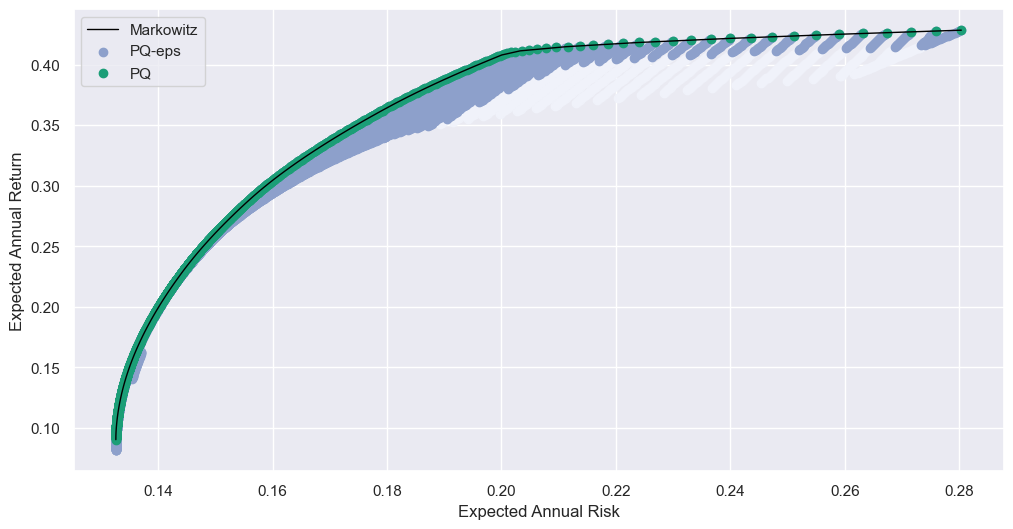

In [37]:
frames = [FA, FA_best_eps, FA_best]
labels = ['', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

In [38]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [39]:
fig = my_plotting.plotting_projection_plotly(FA_3D_best, ef_R)
fig.show()

[]

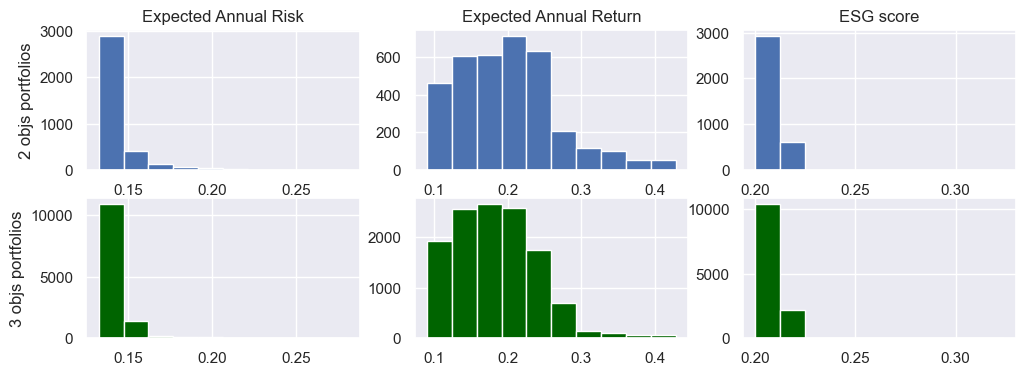

In [40]:
fig = my_plotting.plot_histograms(FA_best, FA_3D_best)
plt.plot()


[]

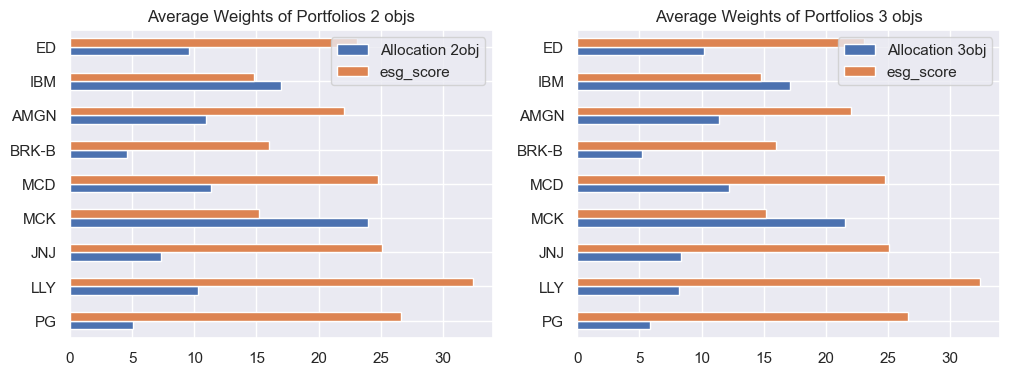

In [41]:
fig = my_plotting.plot_proportions(FA_best, FA_3D_best, X,best_assets, assets_info)
plt.plot()